In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

from line import Line


## Finding and correcting for distortion

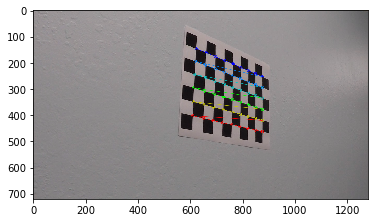

In [2]:
# finding chessboard corners

# prepare object points
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

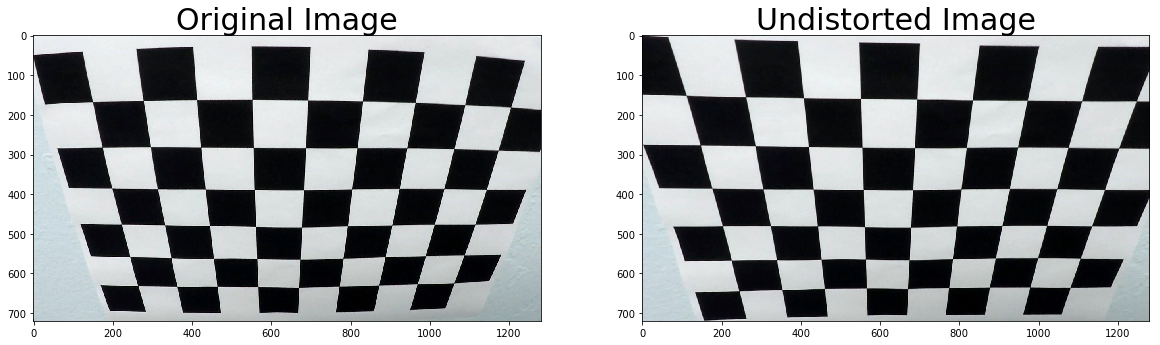

In [3]:
# perform calibration

def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst, mtx, dist

# test on an image
fname = './camera_cal/calibration2.jpg'
img = cv2.imread(fname)

dst, mtx, dist = cal_undistort(img, objpoints, imgpoints)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

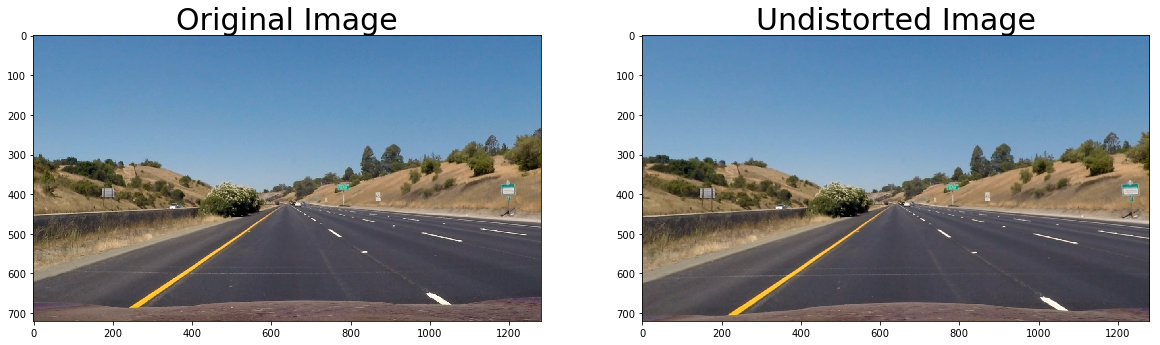

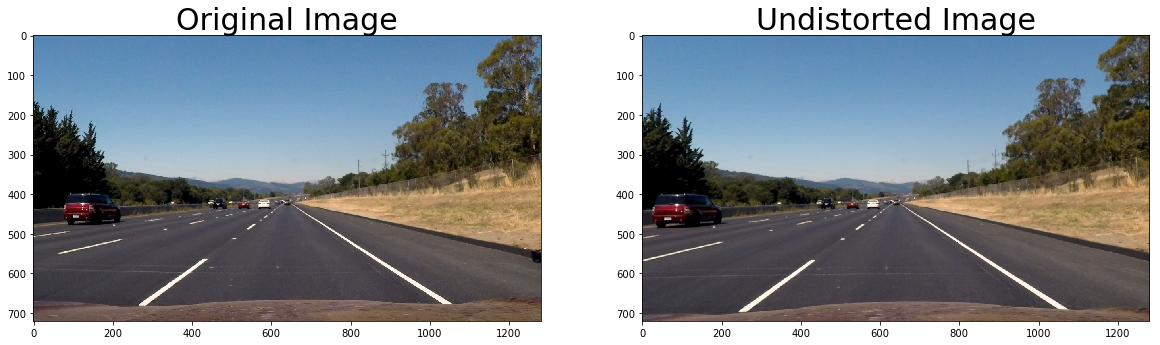

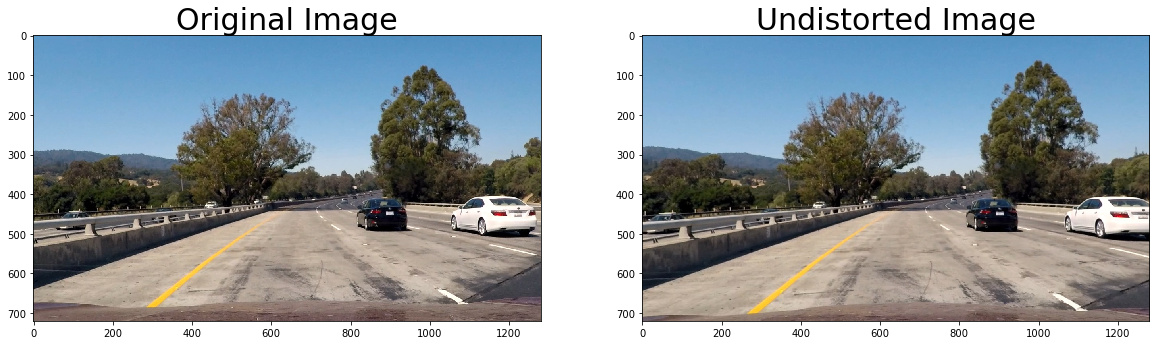

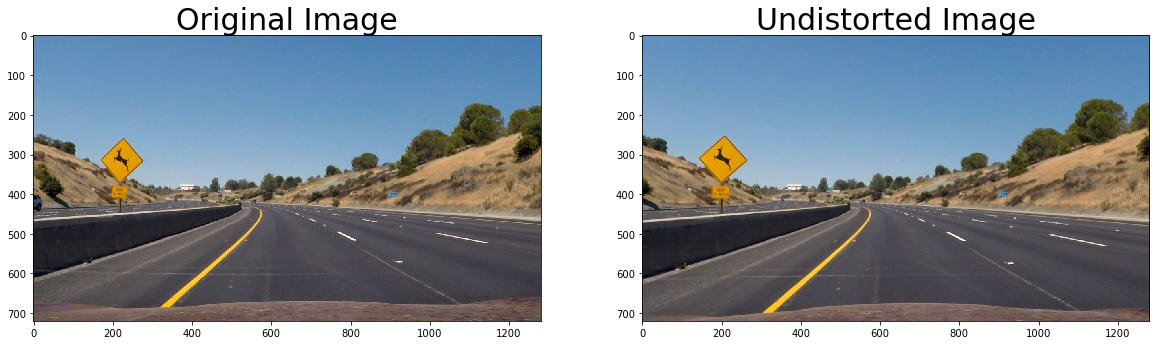

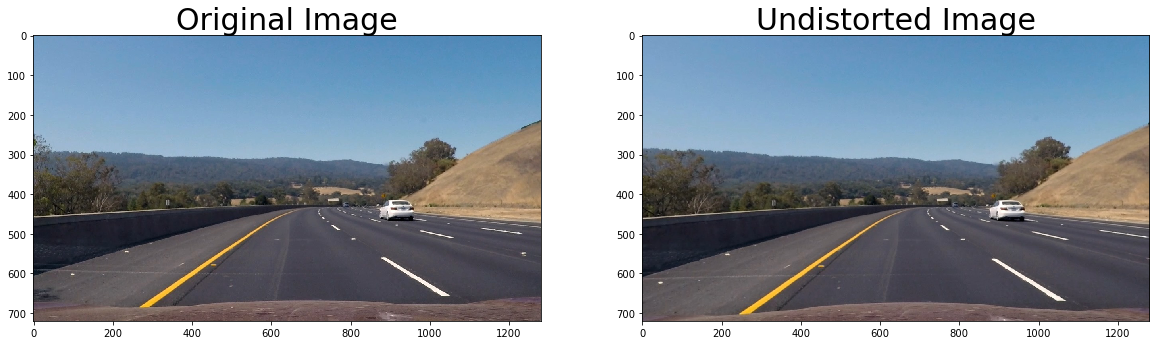

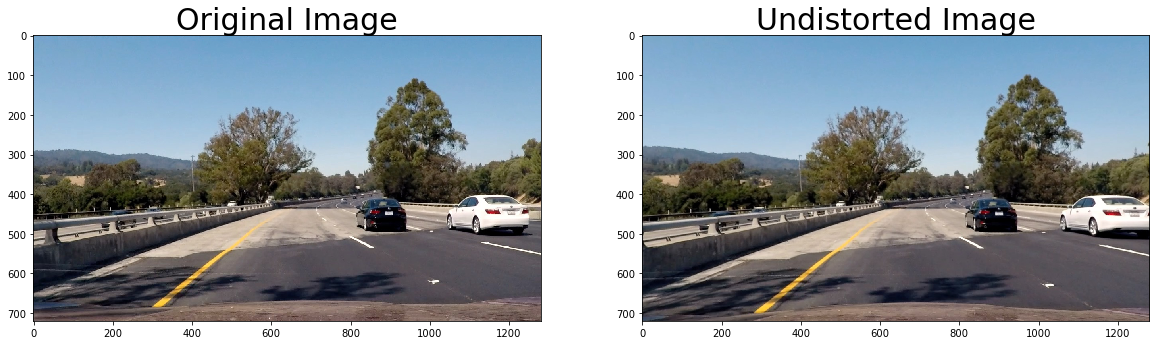

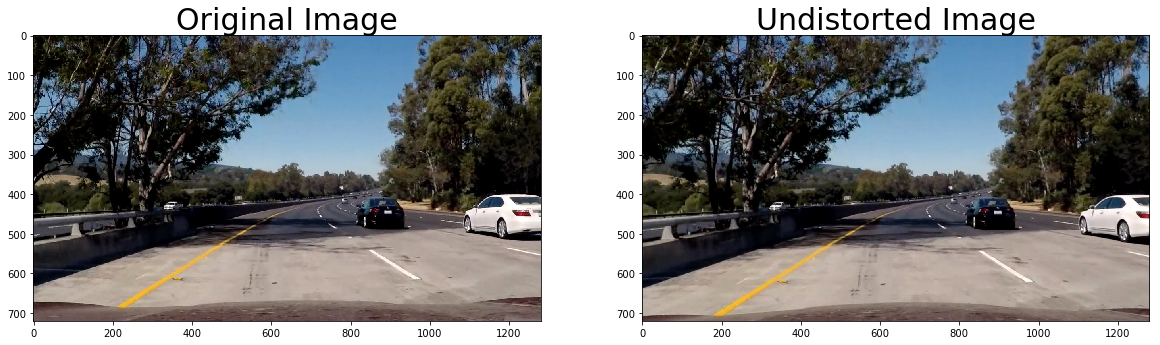

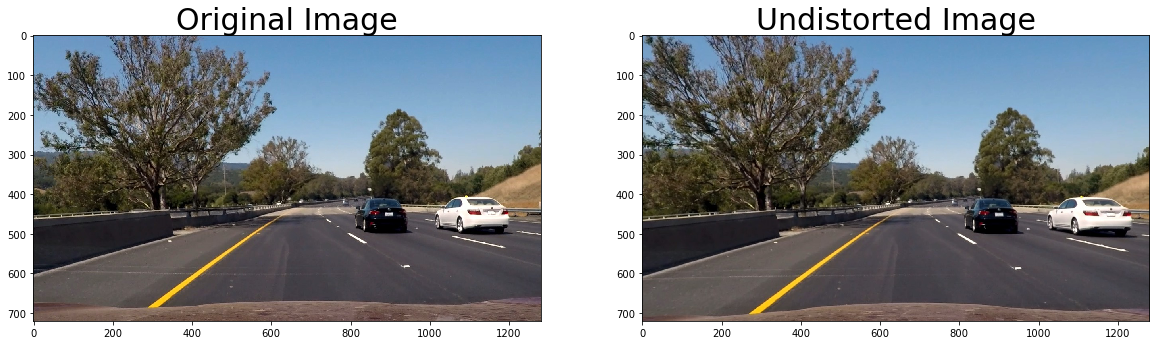

In [4]:
# test undistortions
def test_undistortion(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.show()

images = glob.glob('./test_images/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    test_undistortion(img)

## Building functions for pipeline and testing

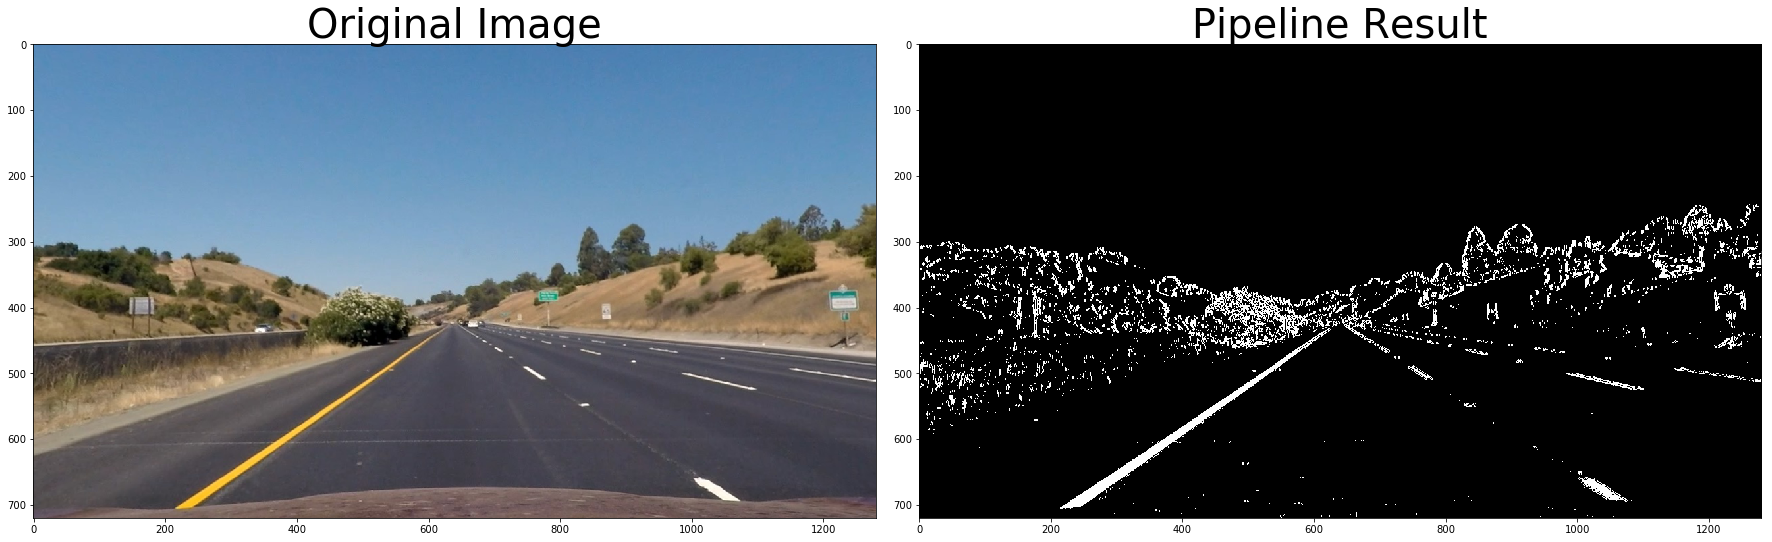

In [21]:
# apply transforms and gradients

def apply_thresholding(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    # combined binary
    combined = np.zeros_like(sxbinary)
    combined[((sxbinary == 1) | (s_binary == 1))] = 1

    return combined
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #return color_binary

fname = './test_images/straight_lines1.jpg'
img = mpimg.imread(fname)
img = cv2.undistort(img, mtx, dist, None, mtx)
result = apply_thresholding(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

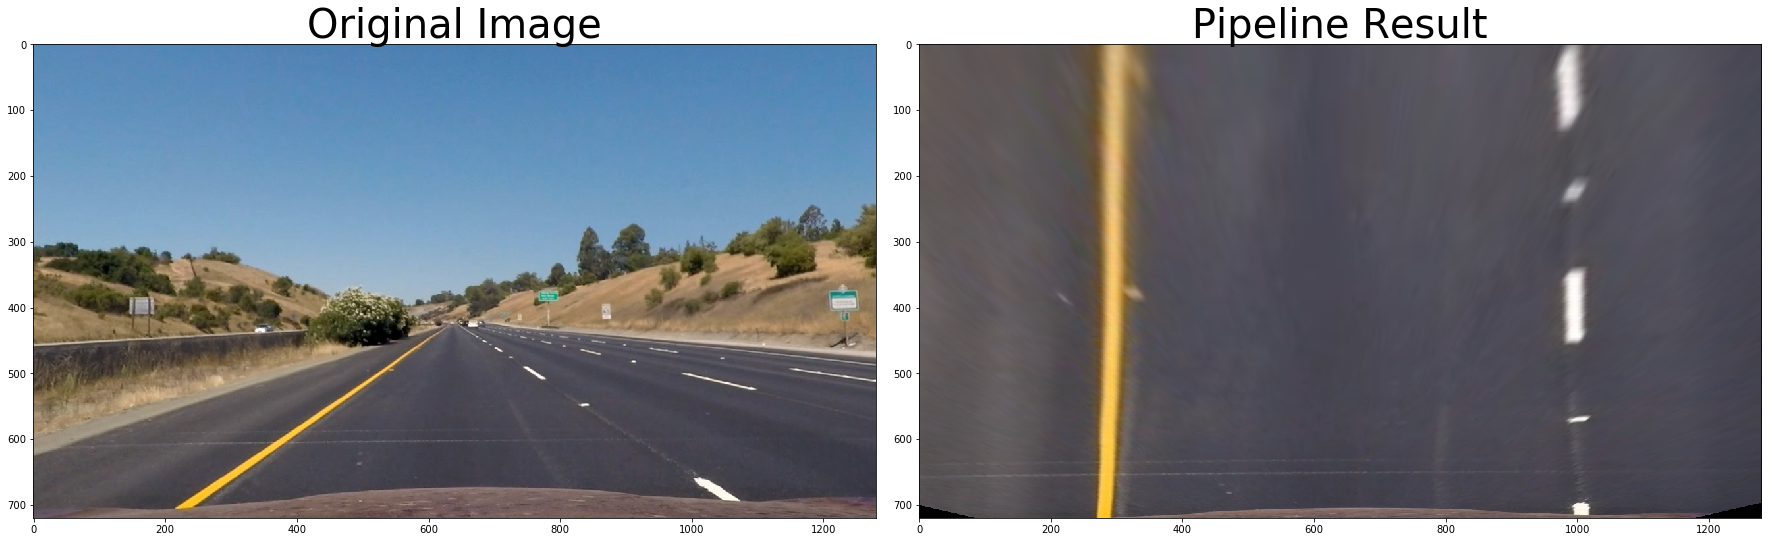

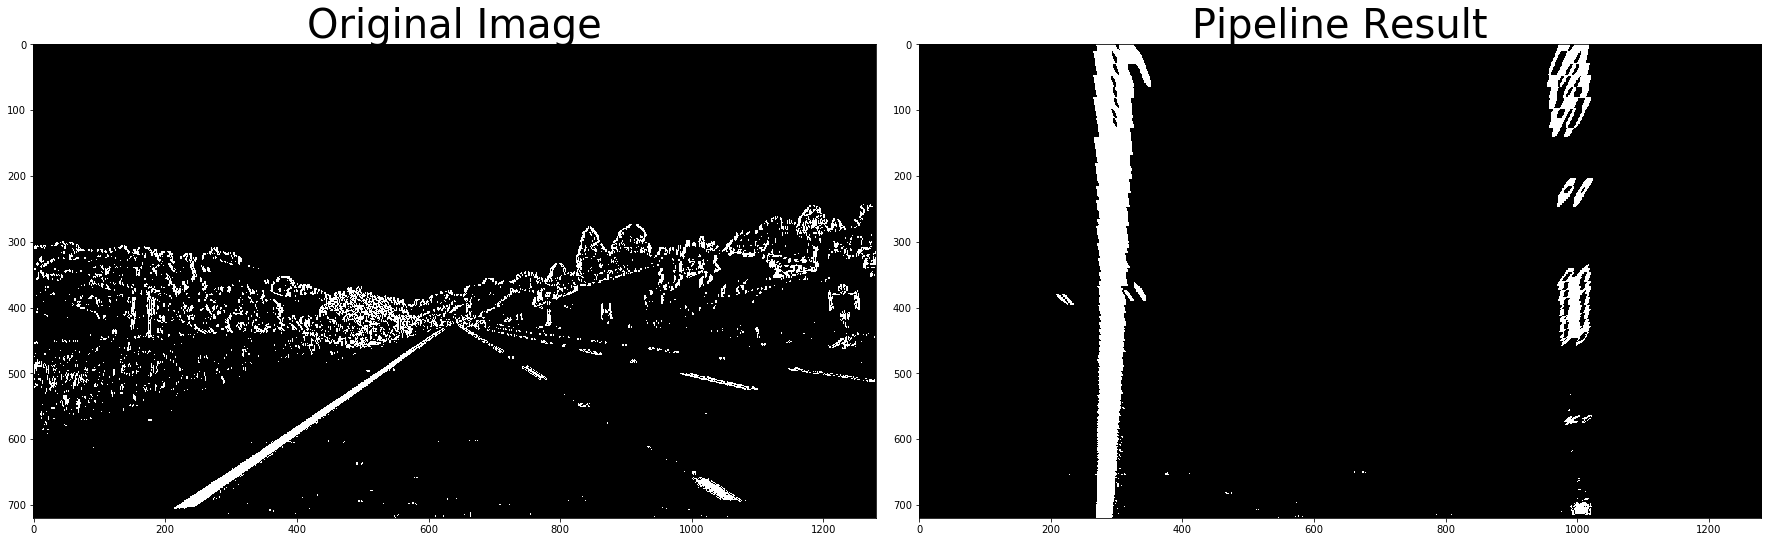

In [22]:
# warp to "birds-eye view"
def warp_image(img, reverse=False):
    #if not reverse:
        #img = cv2.undistort(img, mtx, dist, None, mtx)
    
    img_size = (img.shape[1], img.shape[0])
    # ul - ur - br - bl
    src = np.float32(
        [[(img_size[0] / 2)-58, (img_size[1] / 2)+100],
        [(img_size[0] / 2)+60, (img_size[1] / 2)+100],
        [(img_size[0]) - 230, img_size[1] - 15],
        [250, img_size[1] - 15]])
    
    dst = np.float32(
        [[300, 0],
        [img_size[0]-300, 0],
        [img_size[0]-300, img_size[1]],
        [300, img_size[1]]])
    
    if reverse:
        M = cv2.getPerspectiveTransform(dst, src)
    else:
        M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img_size))
    
    return warped

# test
fname = './test_images/straight_lines1.jpg'
#img = mpimg.imread(fname)
#img = cv2.undistort(img, mtx, dist, None, mtx)
result = warp_image(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# apply to bw thresholded
bwthresh = apply_thresholding(img)
warped_binary = warp_image(bwthresh)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(bwthresh, cmap='gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

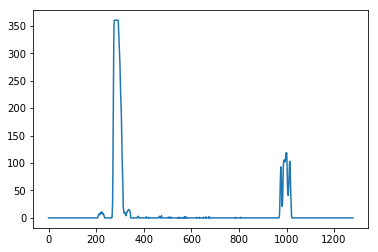

In [23]:
# histogram the lane lines -- just for visualisation
histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

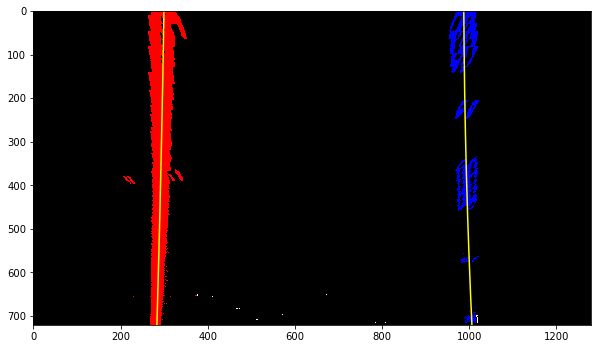

In [24]:
# find lane lines

#histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
#plt.plot(histogram)

def find_lane_lines(warped_binary, left, right):
    histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
    
    # to visualize results
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    
    # find the peak of left and right side
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[:midpoint]) + midpoint
    
    # identify positions of all nonzero pixels
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 100
    
    if not left.detected or not right.detected:
        # sliding windows
        nwindows = 9
        window_height = np.int(warped_binary.shape[0]/nwindows)

        # current positions to update for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # margin to search and minpix to find
        minpix = 50

        # lists to receive lane pixels
        left.lane_inds = []
        right.lane_inds = []

        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped_binary.shape[0] - (window+1)*window_height
            win_y_high = warped_binary.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left.lane_inds.append(good_left_inds)
            right.lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left.lane_inds = np.concatenate(left.lane_inds)
        right.lane_inds = np.concatenate(right.lane_inds)

        # Extract left and right line pixel positions
        left.x_pixelpos = nonzerox[left.lane_inds]
        left.y_pixelpos = nonzeroy[left.lane_inds] 
        right.x_pixelpos = nonzerox[right.lane_inds]
        right.y_pixelpos = nonzeroy[right.lane_inds] 

        # Fit a second order polynomial to each
        left.fit = np.polyfit(left.y_pixelpos, left.x_pixelpos, 2)
        right.fit = np.polyfit(right.y_pixelpos, right.x_pixelpos, 2)
        
    else:
        left.lane_inds = ((nonzerox > (left.fit[0]*(nonzeroy**2) + left.fit[1]*nonzeroy + left.fit[2] - margin)) & (nonzerox < (left.fit[0]*(nonzeroy**2) + left.fit[1]*nonzeroy + left.fit[2] + margin))) 
        right.lane_inds = ((nonzerox > (right.fit[0]*(nonzeroy**2) + right.fit[1]*nonzeroy + right.fit[2] - margin)) & (nonzerox < (right.fit[0]*(nonzeroy**2) + right.fit[1]*nonzeroy + right.fit[2] + margin)))  

        # Extract left and right line pixel positions
        left.x_pixelpos = nonzerox[left.lane_inds]
        left.y_pixelpos = nonzeroy[left.lane_inds] 
        right.x_pixelpos = nonzerox[right.lane_inds]
        right.y_pixelpos = nonzeroy[right.lane_inds] 

        # Fit a second order polynomial to each
        left.fit = np.polyfit(left.y_pixelpos, left.x_pixelpos, 2)
        right.fit = np.polyfit(right.y_pixelpos, right.x_pixelpos, 2)
    
    # -- Drawing functions
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    left_fitx = left.fit[0]*ploty**2 + left.fit[1]*ploty + left.fit[2]
    right_fitx = right.fit[0]*ploty**2 + right.fit[1]*ploty + right.fit[2]

    # color in left and right pix
    out_img[nonzeroy[left.lane_inds], nonzerox[left.lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right.lane_inds], nonzerox[right.lane_inds]] = [0, 0, 255]
    
    return out_img, left_fitx, right_fitx, ploty
    
    
leftl = Line()
rightl = Line()
out_img, left_fitx, right_fitx, ploty = find_lane_lines(warped_binary, leftl, rightl)
plt.figure(figsize=(10,10))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

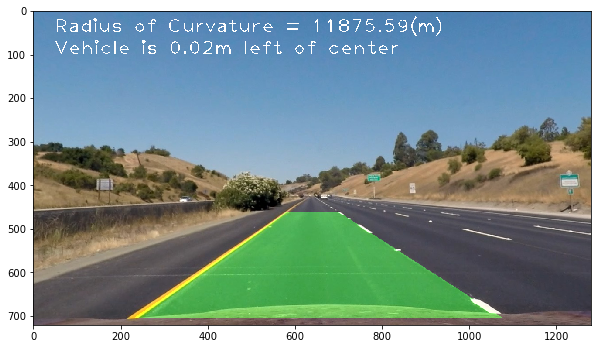

In [25]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# curve detection
def find_curve_and_carlane_pos(warped_binary, left, right):
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    left_fitx = left.fit[0]*ploty**2 + left.fit[1]*ploty + left.fit[2]
    right_fitx = right.fit[0]*ploty**2 + right.fit[1]*ploty + right.fit[2]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    #left.radius_of_curvature = ((1 + (2*left.fit[0]*y_eval + left.fit[1])**2)**1.5) / np.absolute(2*left.fit[0])
    #right.radius_of_curvature = ((1 + (2*right.fit[0]*y_eval + right.fit[1])**2)**1.5) / np.absolute(2*right.fit[0])

    # Fit new polynomials to x,y in world space
    #print(ploty.shape, left.x_pixelpos.shape)
    left_fit_cr = np.polyfit(left.y_pixelpos*ym_per_pix, left.x_pixelpos*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right.y_pixelpos*ym_per_pix, right.x_pixelpos*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left.radius_of_curvature = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right.radius_of_curvature = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left.radius_of_curvature, 'm', right.radius_of_curvature, 'm')
    
    #avg curve
    avg_curve = (left.radius_of_curvature + right.radius_of_curvature) / 2
    
    # lane pos
    car_pos = np.mean(np.concatenate([left_fitx, right_fitx], axis=0)) * xm_per_pix
    lane_mid = (warped_binary.shape[1]/2)*xm_per_pix
    car_off_center = lane_mid - car_pos
    
    # build color warp
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    left.detected = True
    right.detected = True
    
    #print(left.radius_of_curvature, right.radius_of_curvature)
    
    return avg_curve, car_off_center, color_warp
    
avg_curve, car_off_center, color_warp = find_curve_and_carlane_pos(warped_binary, leftl, rightl)

# add text on curve and pos
out = img
if car_off_center < 0.0:
    cartext = "Vehicle is " + "{0:.2f}".format(abs(car_off_center)) + "m left of center"
else:
    cartext = "Vehicle is " + "{0:.2f}".format(abs(car_off_center)) + "m right of center"

radtext =  "Radius of Curvature = " + "{0:.2f}".format(avg_curve) + "(m)"

cv2.putText(img=out, text=radtext, org=(50,50), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness = 2)
cv2.putText(img=out, text=cartext, org=(50,100), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness = 2)

# unwarp to original
unwarped_overlay = warp_image(color_warp, reverse=True)
unwarped_overlay = np.array(unwarped_overlay, np.uint8)


cv2.addWeighted(unwarped_overlay, 0.4, out, 1.0, 0, out)
plt.figure(figsize=(10,10))
plt.imshow(out)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

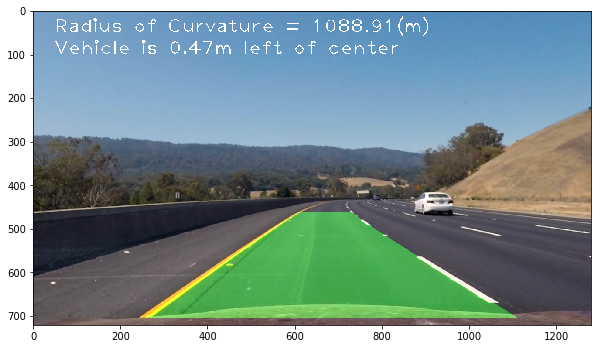

In [55]:
# main pipeline
left = Line()
right = Line()

def main_pipeline(image):
    global left, right
    
    #undistort
    undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
    
    #warp
    warped = warp_image(undistorted_img)
    
    # threshold and warp image
    thresholded = apply_thresholding(undistorted_img)
    warped_thresholded = warp_image(thresholded)
    
    # detect lines
    out_img, left_fitx, right_fitx, ploty = find_lane_lines(warped_thresholded, left, right)
    
    # find curve
    avg_curve, car_off_center, color_warp = find_curve_and_carlane_pos(warped_thresholded, left, right)
    
    # add text on curve and pos
    out = undistorted_img
    if car_off_center < 0.0:
        cartext = "Vehicle is " + "{0:.2f}".format(abs(car_off_center)) + "m left of center"
    else:
        cartext = "Vehicle is " + "{0:.2f}".format(abs(car_off_center)) + "m right of center"
        
    radtext =  "Radius of Curvature = " + "{0:.2f}".format(avg_curve) + "(m)"
    
    cv2.putText(img=out, text=radtext, org=(50,50), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness = 2)
    cv2.putText(img=out, text=cartext, org=(50,100), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=3, color=(255, 255, 255), thickness = 2)
    
    # add overlay
    unwarped_overlay = warp_image(color_warp, reverse=True)
    unwarped_overlay = np.array(unwarped_overlay, np.uint8)
    
    
    cv2.addWeighted(unwarped_overlay, 0.4, out, 1.0, 0, out)
    
    return out

fname = './test_images/test3.jpg'
img = mpimg.imread(fname)

out = main_pipeline(img)
plt.figure(figsize=(10,10))
plt.imshow(out)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [56]:
# Process Video
from moviepy.editor import VideoFileClip

left = Line()
right = Line()

clip_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
processed_clip = clip.fl_image(main_pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:48<00:00,  7.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video.mp4 

Wall time: 2min 49s


In [57]:
# Process challenge Video
from moviepy.editor import VideoFileClip

left = Line()
right = Line()

clip_output = 'challenge_video_output.mp4'
clip = VideoFileClip("challenge_video.mp4")
processed_clip = clip.fl_image(main_pipeline) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:01<00:00,  7.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 2s


---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[calibration1]: ./output_images/calibration1.png "Calibration Image"
[calibration2]: ./output_images/calibration2.png "Undistorted Chessboard"
[undistorted_test]: ./output_images/undistorted_test.png "Undistorted test Image"
[thresholded_binary]: ./output_images/threshold.png "Thresholded Binary Image"
[warped_normal]: ./output_images/warped_normal.png "Warped Normal Image"
[warped_thresholded]: ./output_images/warped_thresholded.png "Warped Thresholded Image"
[warped_histogram]: ./output_images/warped_histogram.png "Warped Thresholded Histogram Image"
[find_lane_lines]: ./output_images/find_lane_lines.png "Found lane lines Image"
[composited_image]: ./output_images/composited_image.png "Composited Image"
[video1]: ./project_video_output.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the section of the IPython notebook labeled "Finding and correcting for distortion".

Building off of the sample code from the class, I built the object points based on the 9x6 shape of the chessboard corners.  I then enumerated through all of the calibration images, converted to grayscale and used the cv2 function findChessboardCorners to update the object point coordinates.

Next, I used the cv2 calibrateCamera function to compute the calibration and distortion coefficients.

In the final cell of this section I tested the undistortion on each of the test images included for the project.

![alt text][calibration1]
![alt text][calibration2]

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

Here is the distortion correction applied to a test image:
![alt text][undistorted_test]

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I created a function, apply_thresholding, to perform the methods to create a thresholded binary image.  I tested combining a few different methods and ultimately ended up on using a similar one to what is done in module 30 of the Advanced Lane Finding portion of the course, combining Sobel Threshold and Threshold color channel into a binary gradient.

![alt text][thresholded_binary]

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

I created a function called warp_image which took two parameters, the image itself and the option to reverse the warp.  I hard-coded my src and destination matrices into this function by taking the shape of the input image and moving from the edges of those points.

This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 582, 460      | 300, 0        | 
| 700, 460      | 980, 0      |
| 1050, 705     | 980, 720      |
| 250, 405      | 300, 720        |

From here I applied the cv2.warpPerspective function to warp to a "birds-eye" view of the lane lines and returned the warped image.

An example on the original image:
![alt text][warped_normal]

And a thresholded binary of the same image that has been warped:
![alt text][warped_thresholded]

And a calculated histogram on the above threshold, showing the likely lane line positions:
![alt text][warped_histogram]

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

In my find_lane_lines function is where I determine the positions of the lane lines.  This function takes the warped thresholded binary image and a left and right Lane() varaibles as parameters.

The function calculated the historgram of the warped binary image, finds the peak positions and calculates the positions of nonzero pixels.  If a lane line hasn't been previously detected a sliding window search is done to find the lane line and update the corrseponding left and right varaibles.  If a lane line was previously detected then the sliding window search is skipped and this is set based on the previous fit.

Finally, an output image containing what was found is returned.  A few other variables are also returned (but only used for testing purposes).

![alt text][find_lane_lines]

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In my function "find_curve_and_carlane_pos" I found the radius of the curvature of the lane and position of the vehicle against center.  The warped binary image and left and right Lane() variables are parameters.

The fit stored in the Lane() variables is used to fit a polynomial against the pixel positions (multiplied by the assumed y and x meters per pixel to get real world meters).  That is then used to calculate the radius of the curvature for the left and right lane lines.

For the car position, earlier the fitted shape of the left and right lines is sampled against the y space..  The mean of the left and right lane lines is taken and assumed to be the car's position.  The lane "middle" is assumted to be halfway inside of the warped binary image.  This is subtracted from the previous car position and set to the distance that the car is off center.

The average curve, car off center distance and a "color warped" image are returned by this function.

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

From the previous function I return this image:

![alt text][composited_image]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

All of the previous code was written into functions so I combined them in a main_pipeline function which performs them all and is fed into fl_image to generate the following video clip:

Here's a [link to my video result](./project_video_output.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

I compiled most of the approaches outlined in the class to make this end result.  It performs reasonably well on the first example but not on the advanced ones.

Although I implemented the Lane() class as suggested it's missing portions.  Most critically, I don't have any code to determine when the line has been "lost" and to have the program do another sliding window search.  I believe if I find a robust way to do this my program would perform much better on the other sample cases.
